In [1]:
import os
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sklearn
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split,RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor,LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error,accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression,LassoCV,Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold,TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.stats import norm, skew 
from scipy import stats
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesClassifier


In [3]:
"""for i, row in tqdm(id_list.iterrows()):
    point = row['Service Point']
    example_ts = pd.read_csv('/work2/05067/nagyz/austin_energy/data/_4_exports_UT/UT_sID_'+str(point)+'_dates_2017.01.01_through_2021.10.01.csv')
    example_ts.index = pd.to_datetime(example_ts.index)
    example_ts = example_ts.resample('H').mean()
    example_ts = example_ts.drop([f'{point} count Value'], axis = 1)
    example_ts = example_ts['2021-02':'2021-02']
    
    
    # condition with energy that outage happen
    energy = example_ts.iloc[:, 0]
    Q3 = np.quantile(energy, 1)
    Q1 = np.quantile(energy, 0.1)
    energy_con = ~energy['2021-02-12':'2021-02-20'].between(Q1, Q3)

    meter_used = example_ts.iloc[:, 1]
    Q3 = np.quantile(meter_used, 1)
    Q1 = np.quantile(meter_used, 0.1)
    meter_used_con = ~meter_used['2021-02-12':'2021-02-20'].between(Q1, Q3)
    
    happen = len(example_ts['2021-02-12':'2021-02-20'][(energy_con) | (meter_used_con)])
    total = len(example_ts['2021-02-12':'2021-02-20'])
    percent = round(happen / total * 100, 5)
    id_list.loc[i, 'is_effected'] = 1 if percent != 0.0 else 0
    id_list.loc[i, 'temporal_percentage'] = percent"""

"for i, row in tqdm(id_list.iterrows()):\n    point = row['Service Point']\n    example_ts = pd.read_csv('/work2/05067/nagyz/austin_energy/data/_4_exports_UT/UT_sID_'+str(point)+'_dates_2017.01.01_through_2021.10.01.csv')\n    example_ts.index = pd.to_datetime(example_ts.index)\n    example_ts = example_ts.resample('H').mean()\n    example_ts = example_ts.drop([f'{point} count Value'], axis = 1)\n    example_ts = example_ts['2021-02':'2021-02']\n    \n    \n    # condition with energy that outage happen\n    energy = example_ts.iloc[:, 0]\n    Q3 = np.quantile(energy, 1)\n    Q1 = np.quantile(energy, 0.1)\n    energy_con = ~energy['2021-02-12':'2021-02-20'].between(Q1, Q3)\n\n    meter_used = example_ts.iloc[:, 1]\n    Q3 = np.quantile(meter_used, 1)\n    Q1 = np.quantile(meter_used, 0.1)\n    meter_used_con = ~meter_used['2021-02-12':'2021-02-20'].between(Q1, Q3)\n    \n    happen = len(example_ts['2021-02-12':'2021-02-20'][(energy_con) | (meter_used_con)])\n    total = len(example_ts

In [40]:
data_dir = './data/'
export_dir = os.path.join(data_dir, '_4_exports_UT')
id_list = pd.read_csv('temporal_percentage1.csv')
id_list.drop('Unnamed: 0',axis=1,inplace=True)
other_daily=pd.read_csv('other_daily.csv')
other_hourly=pd.read_csv('other_hourly.csv')
other_weekly=pd.read_csv('other_weekly.csv')
residential_daily=pd.read_csv('residential_daily.csv')
residential_hourly=pd.read_csv('residential_hourly.csv')
residential_weekly=pd.read_csv('residential_weekly.csv')
commerical_daily=pd.read_csv('commercial_daily.csv')
commercial_weekly=pd.read_csv('commercial_weekly.csv')
commercial_hourly=pd.read_csv('commercial_hourly.csv')
# RESIDENTIAL
residential_daily_praveen=pd.read_csv('residential_daily_praveen.csv')
residential_daily_praveen1=pd.read_csv('residential_daily_praveen_2ndpart of 2017.csv')
residential_daily_praveen2=pd.read_csv('residential_daily_praveen_2021 january.csv')
def convert(s):
    s=s.set_index(s[s.columns[0]])
    s.drop('Unnamed: 0',axis=1,inplace=True)
    s.index=pd.to_datetime(s.index)
    return s
a=convert(residential_daily_praveen1)
a1=convert(residential_daily_praveen)[:'2017-08-02 00:00:00+00:00']
a2=convert(residential_daily_praveen2)
a3=convert(residential_daily)
residential=pd.concat([a3,a2],axis=0)
# commerical
commerical_2017=pd.read_csv('commercial_2021_new_one_part.csv')
commerical_2021=pd.read_csv('commercial_2021_new_one2021_part.csv')
b=convert(commerical_2017)
b1=convert(commerical_2021)
b2=convert(commerical_daily)
commerical=pd.concat([b,b2,b1],axis=0)
residential

,0
Unnamed: 0,
2018-01-01 00:00:00+00:00,628.346108
2018-01-02 00:00:00+00:00,2001.860332
2018-01-03 00:00:00+00:00,2209.102122
2018-01-04 00:00:00+00:00,1713.237830
2018-01-05 00:00:00+00:00,1352.370690
...,...
2021-02-25 00:00:00+00:00,1125.129581
2021-02-26 00:00:00+00:00,1226.888247
2021-02-27 00:00:00+00:00,1084.932271


In [33]:
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']

In [4]:
residential1=residential['2018-01-01':'2020-12-31']

Text(0.5, 1.0, 'residential')

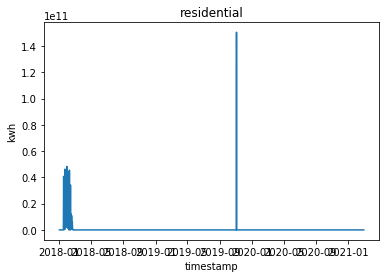

In [5]:
plt.plot(residential)
plt.xlabel('timestamp')
plt.ylabel('kwh')
plt.title('residential')


Text(0.5, 1.0, 'outlier detection')

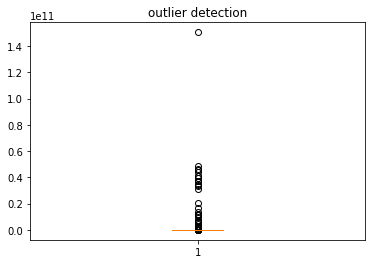

In [6]:
# CHECKING OUTLIERS
plt.boxplot(residential['0'])
plt.title('outlier detection')
# lot of outliers

2927.881196260089

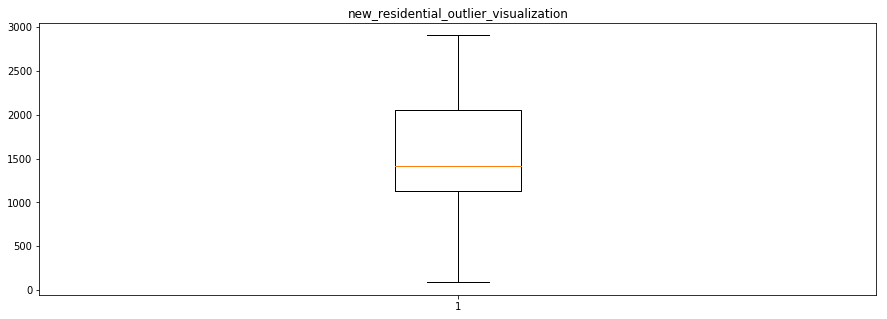

In [7]:
Q3= residential['0'].quantile(0.967)
residential1=residential[residential['0']<Q3]
fig, ax1 = plt.subplots(1, figsize=(15,5))
ax1.boxplot(residential1['0'])
ax1.set_title('new_residential_outlier_visualization')
# NO OUTLIERS NOW
Q3

Text(0.5, 1.0, 'residential')

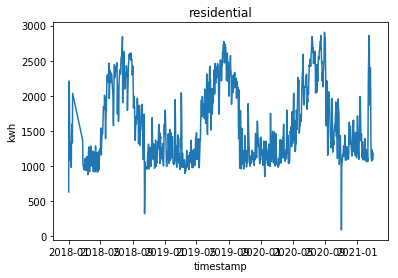

In [8]:
plt.plot(residential1)
plt.xlabel('timestamp')
plt.ylabel('kwh')
plt.title('residential')

In [9]:
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sin']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year
    example_ts['dayofweek_sin']=np.sin(example_ts.index.weekday*(2.*np.pi/7))
    example_ts['dayofweek_cos']=np.cos(example_ts.index.weekday*(2.*np.pi/7))
    example_ts['weekofyear_cos']=np.cos(example_ts.index.weekofyear*(2.*np.pi/52))
    example_ts['weekofyear_sin']=np.sin(example_ts.index.weekofyear*(2.*np.pi/52))


    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourly[weather_austin_hourly.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_daily[weather_austin_daily.index == ts]

    return example_ts

In [10]:
residential_example_ts=make_features(residential1,'daily')
residential_example_ts.head(3)


,0,dayofyear_cos,dayofyear_sin,month_cos,month_sin,year,dayofweek_sin,dayofweek_cos,weekofyear_cos,weekofyear_sin,TMP
Unnamed: 0,,,,,,,,,,,
2018-01-01 00:00:00+00:00,628.346108,0.999852,0.017213,0.866025,0.5,2018,0.000000,1.000000,0.992709,0.120537,-2.1
2018-01-02 00:00:00+00:00,2001.860332,0.999407,0.034422,0.866025,0.5,2018,0.781831,0.623490,0.992709,0.120537,-1.5
2018-01-03 00:00:00+00:00,2209.102122,0.998667,0.051620,0.866025,0.5,2018,0.974928,-0.222521,0.992709,0.120537,3.1


Text(0.5, 1.0, 'weekofyear')

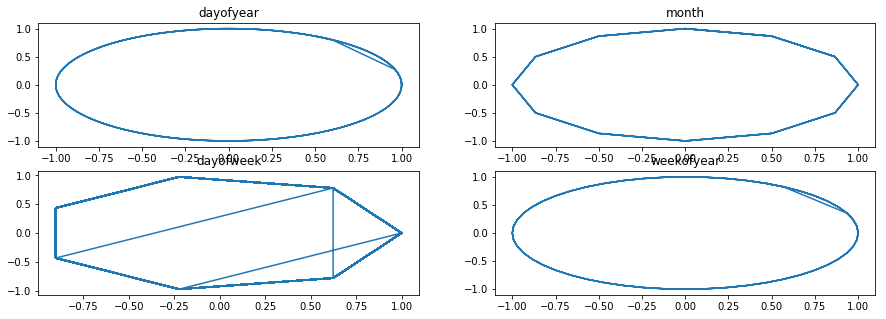

In [11]:
# Cyclic Features
fig, axs = plt.subplots(2,2, figsize=(15,5))
axs[0,0].plot(residential_example_ts['dayofyear_cos'],residential_example_ts['dayofyear_sin'])
axs[0,0].set_title('dayofyear')
axs[0,1].plot(residential_example_ts['month_cos'],residential_example_ts['month_sin'])
axs[0,1].set_title('month')
axs[1,0].plot(residential_example_ts['dayofweek_cos'],residential_example_ts['dayofweek_sin'])
axs[1,0].set_title('dayofweek')
axs[1,1].plot(residential_example_ts['weekofyear_cos'],residential_example_ts['weekofyear_sin'])
axs[1,1].set_title('weekofyear')

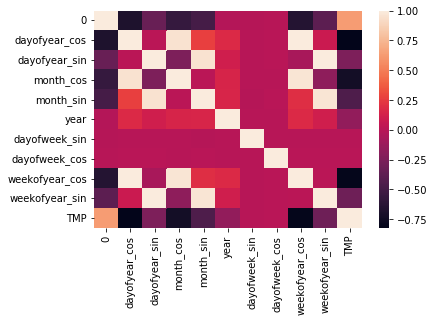

In [12]:
sns.heatmap(residential_example_ts.corr());


Text(0.5, 1.0, 'residential')

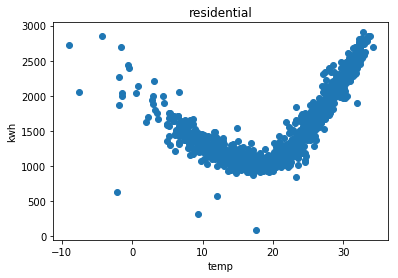

In [15]:
plt.scatter(residential_example_ts['TMP'],residential_example_ts['0'])
plt.xlabel('temp')
plt.ylabel('kwh')
plt.title('residential')

skewness of dayofyear_cos -0.034481513678540486
mean is 0.018629599687907727 and standard deviation is 0.7112404636345722


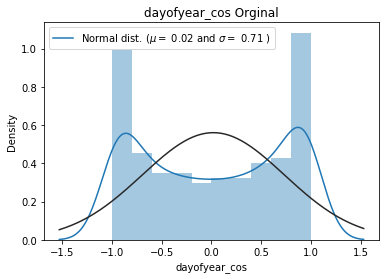

skewness of dayofyear_sin -0.024058746796034258
mean is 0.008689576508241155 and standard deviation is 0.7026481567359688


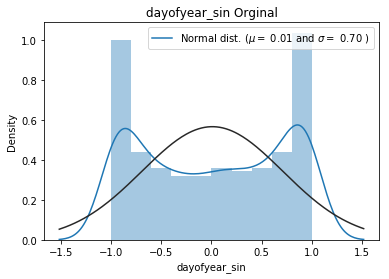

skewness of month_cos -0.026804055481670412
mean is 0.012884785000369875 and standard deviation is 0.7095174436942072


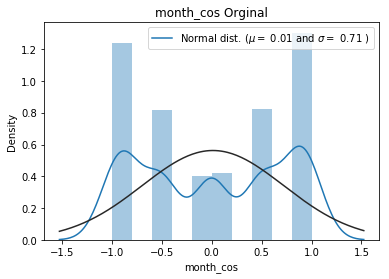

skewness of month_sin -0.030177912469684213
mean is 0.009432317264872151 and standard deviation is 0.704506927432333


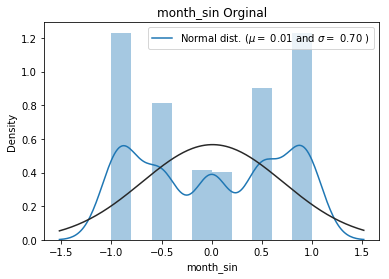

skewness of year 0.15777465176865738
mean is 2019.1405550581917 and standard deviation is 0.9030599805310907


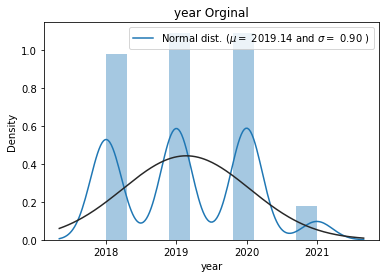

skewness of dayofweek_sin 0.001037915006862977
mean is -0.0005613072236627912 and standard deviation is 0.7069482803906318


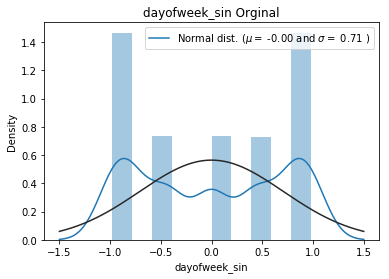

skewness of dayofweek_cos -0.0006334655765592998
mean is 0.0004476275738585169 and standard deviation is 0.707264882074944


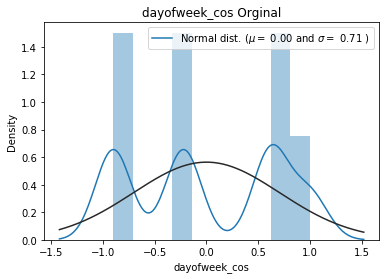

skewness of weekofyear_cos -0.037903363243984745
mean is 0.0221427635245865 and standard deviation is 0.7130332456037207


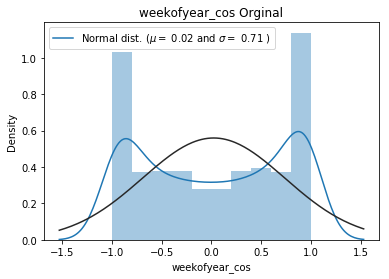

skewness of weekofyear_sin -0.025317864387357423
mean is 0.00798868582573758 and standard deviation is 0.7007349495965617


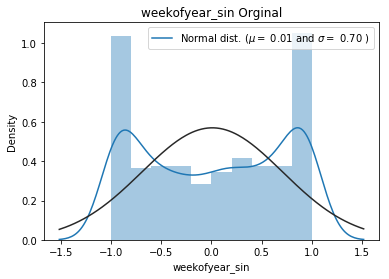

skewness of TMP -0.4873918100970788
mean is 21.07117278424351 and standard deviation is 8.21841457915422


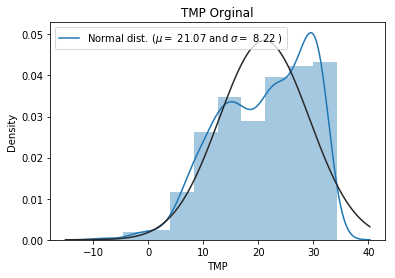

In [73]:
for i in residential_example_ts[residential_example_ts.columns[1:]]:
    sns.distplot(residential_example_ts[i],bins=10,fit=norm);
    print(f'skewness of {i}',skew(residential_example_ts[i]))
    mean,standard_deviation = norm.fit(residential_example_ts[i])
    print('mean is',mean,'and standard deviation is',standard_deviation)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, standard_deviation)],
                    loc = 'best')
    plt.title(f'{i} Orginal')
    plt.show()

In [13]:
#cross validation

X_train=residential_example_ts[residential_example_ts.columns[1:]]['2018-01-01':'2020-07-21']
y_train=residential_example_ts['0']['2018-01-01':'2020-07-21']
X_test=residential_example_ts[residential_example_ts.columns[1:]]['2020-07-21':]
y_test=residential_example_ts['0']['2020-07-21':]
X=residential_example_ts[residential_example_ts.columns[1:]]
y=residential_example_ts['0']

In [14]:
dic={'std scaler':StandardScaler(),'min-max scaler':MinMaxScaler()}
for i in dic.values():
    pipeline_baseline=make_pipeline(i,RandomForestRegressor(random_state=4))
    score=cross_val_score(pipeline_baseline,X,y,cv=10,scoring='r2').mean()
    print(f'Score of model with {i} is ',round(score,4))
#THUS SCALING HAS EFFECT ON OUR R2 SCORE
#STANDARD SCALER HAS MORE EFFECT

Score of model with StandardScaler() is  0.7667
Score of model with MinMaxScaler() is  0.763


10

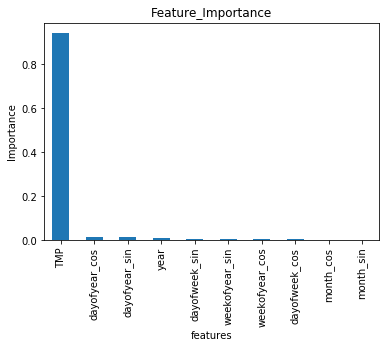

In [17]:
pipeline_baseline1=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=4))
rf=RandomForestRegressor(random_state=4)
rf.fit(X,y)
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
forest_importances.sort_values(ascending=False).plot.bar()
plt.xlabel('features')
plt.ylabel('Importance')
plt.title('Feature_Importance')
X.shape[1]

100%|██████████| 9/9 [12:44<00:00, 84.90s/it] 


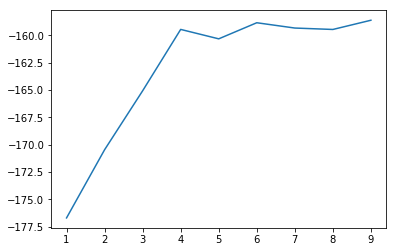

In [88]:
f_scores=[]
no_of_features=[]
for i in tqdm(range(1,X.shape[1])):
    sfs = SequentialFeatureSelector(pipeline_baseline1, n_features_to_select=i,cv=10,scoring='r2')
    sfs.fit(X,y)
    X_new=X[sfs.get_feature_names_out()]
    score=cross_val_score(pipeline_baseline1,X_new,y,cv=10,scoring='neg_root_mean_squared_error').mean()
    f_scores.append(score)
    no_of_features.append(i)
plt.plot(no_of_features,f_scores)

In [18]:
# CROSS VALIDATION# Number of trees in random forest
randomforestregressor__n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 5)]
# Number of features to consider at every split
randomforestregressor__max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
randomforestregressor__max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
randomforestregressor__min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
randomforestregressor__min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'randomforestregressor__n_estimators': randomforestregressor__n_estimators,
               'randomforestregressor__max_features': randomforestregressor__max_features,
               'randomforestregressor__max_depth': randomforestregressor__max_depth,
               'randomforestregressor__min_samples_split': randomforestregressor__min_samples_split,
               'randomforestregressor__min_samples_leaf': randomforestregressor__min_samples_leaf}
print(random_grid)

{'randomforestregressor__n_estimators': [200, 275, 350, 425, 500], 'randomforestregressor__max_features': ['auto', 'sqrt'], 'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'randomforestregressor__min_samples_split': [2, 5, 10], 'randomforestregressor__min_samples_leaf': [1, 2, 4]}


In [19]:
rf_random = RandomizedSearchCV(estimator = pipeline_baseline1, 
                               param_distributions = random_grid,
                               n_iter = 100, 
                               cv = 10, verbose=2, random_state=42, n_jobs = -1,
                               refit=True)
rf_random.fit(X,y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=4))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                                                             70,
                                                                             

In [148]:
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
rf_random = RandomizedSearchCV(estimator = pipeline_baseline1, 
                               param_distributions = random_grid,
                               n_iter = 100, 
                               cv = inner_cv, verbose=2, random_state=42, n_jobs = -1,
                               refit=True)
nested_score = cross_val_score(rf_random, X, y, cv=outer_cv).mean()
print(nested_score)

{'randomforestregressor__n_estimators': 425, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 50}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.9380436780616899


In [20]:
pred_cv_random=rf_random.predict(X_test)

MSE: 112.61464891059201
MAE: 68.19204205616028


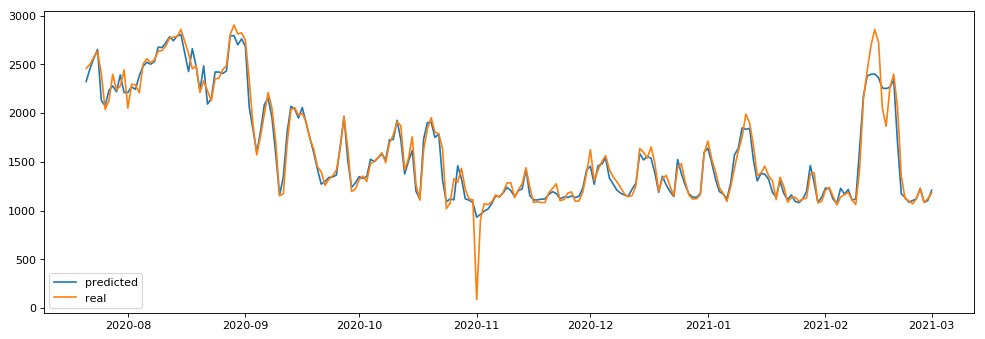

In [21]:
figure(figsize=(15,5), dpi=80)
plt.plot(y_test.index,pred_cv_random,label='predicted')
plt.plot(y_test.index,y_test,label='real')
plt.legend()
print(f'MSE:' ,mean_squared_error(y_test,pred_cv_random,squared=False))
print(f'MAE:' ,mean_absolute_error(y_test,pred_cv_random))
plt.show()

In [54]:
covid=pd.read_csv('resi_covid_.csv')
real_test=convert(covid)
real_test.index

DatetimeIndex(['2021-03-01 00:00:00+00:00', '2021-03-02 00:00:00+00:00',
               '2021-03-03 00:00:00+00:00', '2021-03-04 00:00:00+00:00',
               '2021-03-05 00:00:00+00:00', '2021-03-06 00:00:00+00:00',
               '2021-03-07 00:00:00+00:00', '2021-03-08 00:00:00+00:00',
               '2021-03-09 00:00:00+00:00', '2021-03-10 00:00:00+00:00',
               ...
               '2021-07-22 00:00:00+00:00', '2021-07-23 00:00:00+00:00',
               '2021-07-24 00:00:00+00:00', '2021-07-25 00:00:00+00:00',
               '2021-07-26 00:00:00+00:00', '2021-07-27 00:00:00+00:00',
               '2021-07-28 00:00:00+00:00', '2021-07-29 00:00:00+00:00',
               '2021-07-30 00:00:00+00:00', '2021-07-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Unnamed: 0', length=153, freq=None)

Text(0.5, 1.0, 'residential_covid')

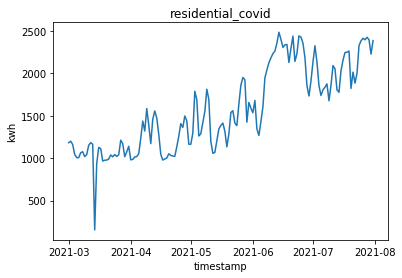

In [55]:
real_test1=real_test['2021-03-02':]
plt.plot(real_test)
plt.xlabel('timestamp')
plt.ylabel('kwh')
plt.title('residential_covid')


In [58]:
real_train=make_features(real_test1,'daily')
real_value=real_train['0']
real_train1=real_train[real_train.columns[1:]]
real_train1

,dayofyear_cos,dayofyear_sin,month_cos,month_sin,year,dayofweek_sin,dayofweek_cos,weekofyear_cos,weekofyear_sin,TMP
Unnamed: 0,,,,,,,,,,
2021-03-02 00:00:00+00:00,0.497513,0.867456,6.123234e-17,1.0,2021,0.781831,0.623490,0.464723,0.885456,12.9
2021-03-03 00:00:00+00:00,0.482508,0.875892,6.123234e-17,1.0,2021,0.974928,-0.222521,0.464723,0.885456,13.6
2021-03-04 00:00:00+00:00,0.467359,0.884068,6.123234e-17,1.0,2021,0.433884,-0.900969,0.464723,0.885456,16.7
2021-03-05 00:00:00+00:00,0.452072,0.891981,6.123234e-17,1.0,2021,-0.433884,-0.900969,0.464723,0.885456,18.8
2021-03-06 00:00:00+00:00,0.436651,0.899631,6.123234e-17,1.0,2021,-0.974928,-0.222521,0.464723,0.885456,15.3
...,...,...,...,...,...,...,...,...,...,...
2021-07-27 00:00:00+00:00,-0.905193,-0.425000,-8.660254e-01,-0.5,2021,0.781831,0.623490,-0.885456,-0.464723,30.3
2021-07-28 00:00:00+00:00,-0.897743,-0.440519,-8.660254e-01,-0.5,2021,0.974928,-0.222521,-0.885456,-0.464723,30.7
2021-07-29 00:00:00+00:00,-0.890028,-0.455907,-8.660254e-01,-0.5,2021,0.433884,-0.900969,-0.885456,-0.464723,29.3


MSE: 126.24357598910532
MAE: 86.63110167400329


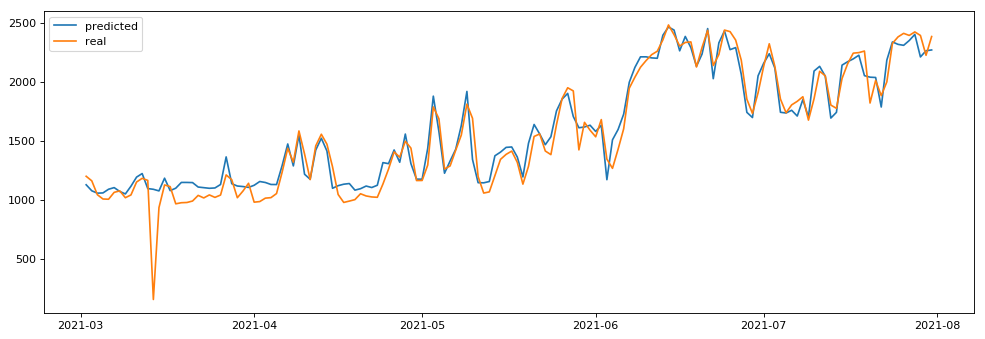

In [60]:
covid_pred=rf_random.predict(real_train1)
figure(figsize=(15,5), dpi=80)
plt.plot(real_train1.index,covid_pred,label='predicted')
plt.plot(real_train1.index,real_value,label='real')
plt.legend()
print(f'MSE:' ,mean_squared_error(real_value,covid_pred,squared=False))
print(f'MAE:' ,mean_absolute_error(real_value,covid_pred))
plt.show()

Text(0.5, 1.0, 'impact of covid 19')

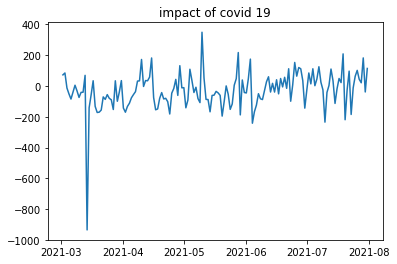

In [63]:
plt.plot(real_value-covid_pred)
plt.title('impact of covid 19')